In [1]:
import sys
sys.path.append('../utils')
import mesh_tools as mt
import torch
import torch.nn as nn
from custom_voronoi import VoronoiValues
from meshplot import plot
import numpy as np
import numpy as np
from pytorch3d.ops import knn_points
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
from plyfile import PlyData, PlyElement
scene = 'bonsai'
path_to_pretrained = f'../../radfoam_original/output/{scene}/scene.ply'
plydata = PlyData.read(path_to_pretrained)

In [4]:
xyz = np.column_stack((np.array(plydata.elements[0].data['x']), np.array(plydata.elements[0].data['y']), np.array(plydata.elements[0].data['z'])))
density = np.array(plydata.elements[0].data['density'])

max_l = 3
mask = ((xyz<max_l)*(xyz>-max_l)).all(-1)
xyz = xyz[mask]/max_l
density = density[mask]

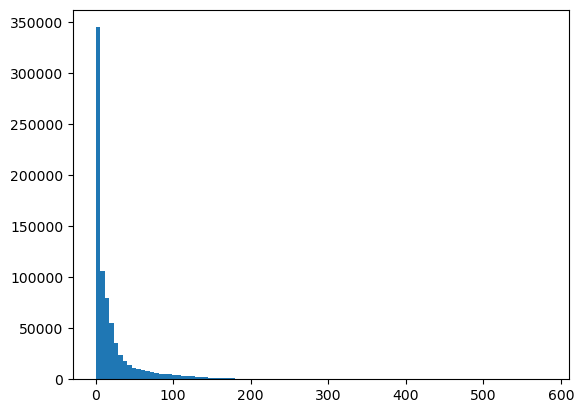

In [5]:
plt.hist(density, bins=100)
plt.show()

In [6]:
subf=1
density_treshold = 50

V = VoronoiValues(xyz[::subf], density[::subf]-density_treshold)
nv, nf = V.to_mesh()


In [7]:
mt.export_obj(nv, nf, 'voronoi_bonsai.obj')

In [ ]:
!du -sh voronoi_bonsai.obj.obj

94M	voronoi_bonsai.obj.obj


In [11]:
sys.path.append('../')
import configargparse
from configs import ModelParams, DatasetParams
from radfoam_model.mesh_utils import marching_tetrahedra
from radfoam_model.scene import RadFoamScene
device = 'cuda'

colors = torch.tensor(
    np.array([plydata.elements[0].data["red"], plydata.elements[0].data["green"], plydata.elements[0].data["blue"]]),
    dtype=torch.uint8
).T  # (N, 3)

scene = "bonsai"
path_to_pretrained = f'../../radfoam_original/output/{scene}/model.pt'
parser = configargparse.ArgParser(
        # default_config_files=["arguments/mipnerf360_outdoor_config.yaml"]
    )

model_args = ModelParams(parser)
model = RadFoamScene(args=model_args, device=device, attr_dtype=torch.float16)
model.load_pt(path_to_pretrained)

primal_features = colors[mask].cuda()
primal_values = torch.from_numpy(density[::subf]-density_treshold).to(device=device)
xyz_cuda = torch.from_numpy(xyz).to(device)
v, f, feat = marching_tetrahedra(model.triangulation.tets().long(),primal_values ,xyz_cuda , primal_features)
feat /= feat.max()

In [17]:
mt.export_obj(v.detach().cpu().numpy(), f.detach().cpu().numpy(), 'mt_bonsai')

In [18]:
!du -sh mt_bonsai.obj

153M	mt_bonsai.obj
